# T4 Clustering: algoritmo K-medias

# Índice

1. Clustering particional
2. Criterio suma de errores cuadráticos
3. Algoritmo $K$-medias de Duda y Hart
4. Algoritmo $K$-medias convencional
5. Algoritmo de Lloyd
6. Evaluación del clustering

# 1 Clustering particional

**Clustering particional:** $\;$ dado un conjunto de $N$ datos $\mathcal{D}$ y un número de clusters $K,\,$ el clustering particional consiste en optimizar alguna función criterio $J(\Pi)$ para evaluar la calidad de cualquier partición $\Pi$ de los datos en $K$ clústeres
$$\Pi^* = \operatorname*{argopt}_{\Pi} J(\Pi)$$

**Intractabilidad:** $\;$ el clustering particional es en general un problema intratable puesto que el número de particiones a explorar crece exponencialmente con $N$ y $K$ (ver [números de Stirling del segundo tipo](https://en.wikipedia.org/wiki/Stirling_numbers_of_the_second_kind))

**Aproximación usual:** $\;$ hacemos uso de algoritmos aproximados para optimizar un criterio particular como por ejemplo la suma de errores cuadráticos

# 2 Criterio suma de errores cuadráticos

**Suma de errores cuadráticos (SEC):** $\;$ de una partición $\Pi=\{X_1,\dotsc,X_K\}$
$$J(\Pi) = \sum_{k=1}^K J_k%
\quad\text{con}\quad%
J_k = \sum_{\boldsymbol{x}\in X_k} \lVert{\boldsymbol{x}-\boldsymbol{m}_k}\rVert_2^2
\quad\text{y}\quad%
\boldsymbol{m}_k = \frac{1}{\lvert X_k\rvert}\sum_{\boldsymbol{x}\in X_k} \boldsymbol{x}$$

**Interpretación:**
* Cada clúster $k$ se representa por su **centroide** o **media** $\,\boldsymbol{m}_k$
* Si $\boldsymbol{x}$ pertenece al clúster $k$, $\boldsymbol{x}-\boldsymbol{m}_k$ es el **vector error** obtenido al representar $\boldsymbol{x}$ con $\boldsymbol{m}_k$
* El error asociado a $\boldsymbol{x}$ se mide con la norma Euclidiana de su vector error, $\lVert{\boldsymbol{x}-\boldsymbol{m}_k}\rVert_2$
* Denominamos **distorsión** del clúster $k$, $\,J_k,\,$ a la suma de errores al cuadrado de sus datos
* El criterio SEC es la suma de las distorsiones de todos los clusters i, obviamente, es un criterio a minimizar
* Idealmente, esperamos clusters hiper-esféricos compactos y de tamaño parecido, sobre $K$ medias bien separadas
* Si la partición natural de los datos es distinta a la esperada, es probable que la minimización de la SEC no la encuentre

**Ejemplo:** $\;$ cálculo de la SEC para $\Pi=\{X_1=\{(1, 7)^t, (4, 2)^t, (4,6)^t\}, X_2=\{(8, 2)^t, (8, 6)^t\}\}$
$$\begin{align*}
\boldsymbol{m}_1&=(3,5)^t&&J_1=8+10+2=20\\
\boldsymbol{m}_2&=(8,4)^t&&J_2=4+4=8
\end{align*}$$
$$J=J_1+J_2=28$$

In [1]:
import numpy as np; np.set_printoptions(precision=2)
def SEQ(X, y): # labels from 0 to K-1 for simplicity
    N, D = X.shape; K = np.max(y)+1; J = 0.0; m = np.zeros((K, D)); S = np.zeros(K).astype(int)
    for k in range(K):
        Xk = np.squeeze(X[np.where(y==k),:]); S[k] = Xk.shape[0]; 
        m[k] = Xk.mean(axis=0); J += np.square(Xk - m[k]).sum()
    return J, m, S
X = np.array([[1, 7], [4, 2], [4, 6], [8, 2], [8, 6]]); y = np.array([0, 0, 0, 1, 1])
J, m, S = SEQ(X, y); print(f'J = {J:.2f} m = {m.reshape(1, -1)} S = {S}')

J = 28.00 m = [[3. 5. 8. 4.]] S = [3 2]


# 3 Algoritmo $K$-medias de Duda y Hart

**Incremento de SEC al transferir un dato de clúster:** $\;$ si se transfiere un dato $\boldsymbol{x}$ del clúster $i$ al $j$, el incremento de SEC es
$$\Delta J = \frac{\lvert X_j\rvert}{\lvert X_j\rvert + 1}\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2-\frac{\lvert X_i\rvert}{\lvert X_i\rvert - 1}\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$$

**Condición DH:** $\;$ conviene transferir si $\Delta J<0,$ es decir, si se incrementa menos $J$ en $X_j$ del que se decrementa en $X_i$
$$\frac{\lvert X_j\rvert}{\lvert X_j\rvert + 1}\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2<\frac{\lvert X_i\rvert}{\lvert X_i\rvert - 1}\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$$

**Algoritmo $K$-medias de Duda y Hart:** $\;$ para cada dato, busca la transferencia de menor $\Delta J$ y la aplica si cumple DH
> **Entrada:** $\;$ una partición inicial, $\,\Pi=\{X_1,\dotsc,X_K\}$ <br>
> **Salida:** $\;$ una partición optimizada, $\,\Pi^*=\{X_1,\dotsc,X_K\}$ <br>
> Calcular medias y $J$ <br>
> `repetir`
>> `para todo` $\;$ dato $\,\boldsymbol{x}$ <br>
>>> Sea $i$ el clúster en el que se encuentra $\boldsymbol{x}$ <br>
>>> Encontrar un $j\neq i$ que minimice $\,\triangle J\,$ al transferir $\,\boldsymbol{x}\,$ de $i$ a $j$ <br>
>>> `si` $\,\triangle J<0:\;$ transferir $\boldsymbol{x}$ de $i$ a $j$ y actualizar medias y $J$ <br>
>
> `hasta que` $\;$ no se encuentre ninguna transferencia provechosa

**Implementación:** $\;$ función para problemas sencillos

In [2]:
import numpy as np; np.set_printoptions(precision=2, linewidth=np.inf)
def kmeansDH(X, y, max_iter=10, verbose=0):
    N = X.shape[0]; J, m, S = SEQ(X, y); z = y.copy(); notransfer = 0
    for iter in range(max_iter):
        for n in range(N):
            x = X[n, :]; i = z[n]
            if S[i] == 1: continue
            D = np.square(x - m).sum(axis=1); Di = S[i] / (S[i] - 1.0) * D[i]
            D = S / (S + 1.0) * D; D[i] = np.inf; j = np.argmin(D); Dj = D[j]; DJ = Dj - Di
            if verbose > 0: print(f'{iter} {x} {Di:.2f} {Dj:.2f} {DJ:.2f}', end=" ")
            if DJ < 0.0:
                z[n] = j; S[i] -= 1; S[j] += 1; J += DJ; notransfer = 1
                m[i] = m[i] - (x - m[i]) / S[i]; m[j] = m[j] + (x - m[j]) / S[j]
                if verbose > 0: print(f'=> z ={z} m = {m.reshape(1, -1)} J = {J:.2f}')
            else: print("=> no transfer"); notransfer += 1
            if notransfer == N: break
        if notransfer == N: break
    return J, m, z

**Ejemplo (cont.):** $\quad X_1=\{\boldsymbol{x}_1=(1, 7)^t, \boldsymbol{x}_2=(4, 2)^t, \boldsymbol{x}_3=(4,6)^t\}\quad X_2=\{\boldsymbol{x}_4=(8, 2)^t, \boldsymbol{x}_5=(8, 6)^t\}$
<center>

|$\boldsymbol{x}$|$i$|$j$|$\frac{\lvert X_i\rvert}{\lvert X_i\rvert - 1}\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$|$\frac{\lvert X_j\rvert}{\lvert X_j\rvert + 1}\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2$|$\triangle J$|$X_1$|$X_2$|$\boldsymbol{m}_1$|$\boldsymbol{m}_2$|$J$|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|||||||$\{\boldsymbol{x}_1,\boldsymbol{x}_2,\boldsymbol{x}_3\}$|$\{\boldsymbol{x}_4,\boldsymbol{x}_5\}$|$(3,5)^t$|$(8,4)^t$|$28$|
|$\boldsymbol{x}_1$|$1$|$2$|$\frac{3}{2}\cdot 8=12$|$\frac{2}{3}\cdot 58=38.67$|$\frac{80}{3}=26.67$||||
|$\boldsymbol{x}_2$|$1$|$2$|$\frac{3}{2}\cdot 10=15$|$\frac{2}{3}\cdot 20=13.33$|$-\frac{5}{3}=-1.67$|$\{\boldsymbol{x}_1,\boldsymbol{x}_3\}$|$\{\boldsymbol{x}_2,\boldsymbol{x}_4,\boldsymbol{x}_5\}$|$\left(\frac{5}{2},\frac{13}{2}\right)^t$|$\left(\frac{20}{3},\frac{10}{3}\right)^t$|$26.33$|
|$\boldsymbol{x}_3$|$1$|$2$|$\frac{2}{1}\cdot\frac{10}{4}=5$|$\frac{3}{4}\cdot\frac{128}{9}=10.67$|$\frac{17}{3}=5.67$|
|$\boldsymbol{x}_4$|$2$|$1$|$\frac{3}{2}\cdot\frac{32}{9}=5.33$|$\frac{2}{3}\cdot\frac{101}{2}=33.67$|$\frac{85}{3}=28.33$|
|$\boldsymbol{x}_5$|$2$|$1$|$\frac{3}{2}\cdot\frac{80}{9}=13.33$|$\frac{2}{3}\cdot\frac{61}{2}=20.33$|$7$|
|$\boldsymbol{x}_1$|$1$|$2$|$\frac{2}{1}\cdot\frac{5}{2}=5$|$\frac{3}{4}\cdot\frac{410}{9}=34.17$|$\frac{175}{6}=29.17$|

</center>

In [3]:
X = np.array([[1, 7], [4, 2], [4, 6], [8, 2], [8, 6]]); y = np.array([0, 0, 0, 1, 1])
J, m, z = kmeansDH(X, y, max_iter=3, verbose=1)
print(f'{z} {m.reshape(1, -1)} {J:.2f}')

0 [1 7] 12.00 38.67 26.67 => no transfer
0 [4 2] 15.00 13.33 -1.67 => z =[0 1 0 1 1] m = [[2.5  6.5  6.67 3.33]] J = 26.33
0 [4 6] 5.00 10.67 5.67 => no transfer
0 [8 2] 5.33 33.67 28.33 => no transfer
0 [8 6] 13.33 20.33 7.00 => no transfer
1 [1 7] 5.00 34.17 29.17 => no transfer
[0 1 0 1 1] [[2.5  6.5  6.67 3.33]] 26.33


# 4 Algoritmo $K$-medias convencional

**Condición convencional:** $\;$ conviene transferir $\boldsymbol{x}$ del clúster $i$ al $j$ si
$$\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2<\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$$

**Relación con la condición DH:** $\;$ la convencional es suficiente (pero no necesaria; ver ejemplo)
$$\frac{\lvert X_j\rvert}{\lvert X_j\rvert + 1}\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2<\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2\overset{?}{<}\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2<\frac{\lvert X_i\rvert}{\lvert X_i\rvert - 1}\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$$

**Algoritmo $K$-medias convencional:**
> **Entrada:** $\;$ una partición inicial, $\,\Pi=\{X_1,\dotsc,X_K\}$ <br>
> **Salida:** $\;$ una partición optimizada, $\,\Pi^*=\{X_1,\dotsc,X_K\}$ <br>
> `repetir`
>> Calcular las medias de los clusters <br>
>> Reclasificar los datos según las medias más próximas<br>
>
> `hasta que` $\;$ no se reclasifique ningún dato

**Implementación:** $\;$ función para problemas sencillos

In [4]:
import numpy as np; np.set_printoptions(precision=2, linewidth=np.inf)
def kmeans(X, y, max_iter=10, verbose=0):
    N = X.shape[0]; z = y.copy()
    for iter in range(max_iter):
        J, m, _ = SEQ(X, z); transfers = 0
        for n in range(N):
            x = X[n, :]; i = z[n]; D = np.square(x - m).sum(axis=1)
            Di = D[i]; D[i] = np.inf; j = np.argmin(D); Dj = D[j]
            if verbose > 0: print(f'{iter} {x} {Di:.2f} {Dj:.2f}', end=" ")
            if Dj < Di:
                z[n] = j; transfers += 1
                if verbose > 0: print(f'=> z ={z}')
            else: print("=> no transfer");
        if transfers == 0: break
    return J, m, z

**Ejemplo (cont.):** $\quad X_1=\{\boldsymbol{x}_1=(1, 7)^t, \boldsymbol{x}_2=(4, 2)^t, \boldsymbol{x}_3=(4,6)^t\}\quad X_2=\{\boldsymbol{x}_4=(8, 2)^t, \boldsymbol{x}_5=(8, 6)^t\}$
<center>

|$\boldsymbol{x}$|$i$|$j$|$\lVert\boldsymbol{x}-\boldsymbol{m}_i\rVert_2^2$|$\lVert\boldsymbol{x}-\boldsymbol{m}_j\rVert_2^2$|$X_1$|$X_2$|$\boldsymbol{m}_1$|$\boldsymbol{m}_2$|$J$|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
||||||$\{\boldsymbol{x}_1,\boldsymbol{x}_2,\boldsymbol{x}_3\}$|$\{\boldsymbol{x}_4,\boldsymbol{x}_5\}$|$(3,5)^t$|$(8,4)^t$|$28$|
|$\boldsymbol{x}_1$|$1$|$2$|$8$|$58$||||
|$\boldsymbol{x}_2$|$1$|$2$|$10$|$20$|
|$\boldsymbol{x}_3$|$1$|$2$|$2$|$20$|
|$\boldsymbol{x}_4$|$2$|$1$|$34$|$4$|
|$\boldsymbol{x}_5$|$2$|$1$|$26$|$4$|

</center>

In [5]:
X = np.array([[1, 7], [4, 2], [4, 6], [8, 2], [8, 6]]); y = np.array([0, 0, 0, 1, 1])
J, m, z = kmeans(X, y, max_iter=1, verbose=1)
print(f'{z} {m.reshape(1, -1)} {J:.2f}')

0 [1 7] 8.00 58.00 => no transfer
0 [4 2] 10.00 20.00 => no transfer
0 [4 6] 2.00 20.00 => no transfer
0 [8 2] 4.00 34.00 => no transfer
0 [8 6] 4.00 26.00 => no transfer
[0 0 0 1 1] [[3. 5. 8. 4.]] 28.00


# 5 Algoritmo de Lloyd

**Partición de mínima SEC para centroides dados:** $\;$ fácil; cada dato se asigna a su centroide más próximo

**Criterio SEC en función de centroides:** $\;$ es decir, en función de la partición de mínima SEC para centroides dados
$$J(\boldsymbol{m}_1,\dotsc,\boldsymbol{m}_K)%
=\sum_{n=1}^N \; \min_{k=1,\dotsc,K} \; \lVert{\boldsymbol{x_n}-\boldsymbol{m}_k}\rVert_2^2$$

**Algoritmo de Lloyd:** $\;$ algoritmo $K$-medias convencional expresado en función de centroides
> **Entrada:** $\;$ datos y centroides iniciales <br>
> **Salida:** $\;$ centroides optimizados <br>
> `repetir`
>> Asignar cada dato a su centroide más pròximo<br>
>> Recalcular cada centroide com la media de sus datos asignados
>
> `hasta que` $\;$ los centroides recalculados no se diferencien significativamente de los anteriores

**Ejemplo:** $\;$ $K$-medias aplicado a iris

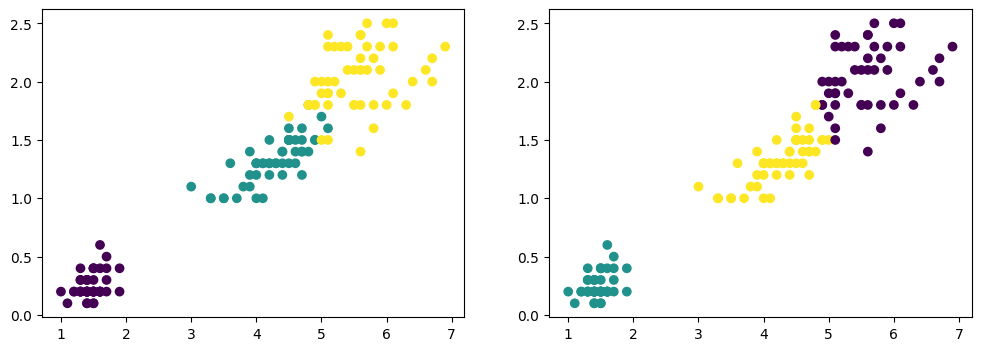

In [7]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
iris = load_iris(); X = iris.data[:, [2, 3]]; y = iris.target
K = 3 # <<< elige número de clusters
y_pred = KMeans(n_clusters=K, n_init=1, random_state=42).fit(X).predict(X)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].scatter(*X.T, c=y); axes[1].scatter(*X.T, c=y_pred);

# 6 Evaluación del clustering

**Índex Rand:** $\;$ medida de similitud entre dos particiones (o etiquetados) de un conjunto $X$ de $N$ datos, una de referencia, $\,R=\{R_1,\dotsc,R_C\}\,$ y otra predicha, $\,P=\{P_1,\dotsc,P_K\}$
$$\operatorname{RI}=\frac{a+b}{a+b+c+d}$$
* $a$ es el número de pares de $X$ que se encuentran en el **mismo** clúster de $R$ y en el **mismo** clúster de $P$
* $b$ es el número de pares de $X$ que se encuentran en **diferentes** clústeres de $R$ y en **diferentes** clústeres de $P$
* $c$ es el número de pares de $X$ que se encuentran en el **mismo** clúster de $R$ y en **diferentes** clústeres de $P$
* $d$ es el número de pares de $X$ que se encuentran en **diferentes** clústeres de $R$ y en el **mismo** clúster de $P$
* Se calcula a partir de todos los $N(N-1)$ pares ordenados o, más fácilmente, a partir de todos los $N(N-1)/2$ desordenados

**Interpretación:** $\;\operatorname{RI}\in[0,1]$
* $\operatorname{RI}=0\,$ si y solo si $R$ y $P$ no están de acuerdo en ningún par
* $\operatorname{RI}=1\,$ si y solo si $R$ y $P$ coinciden (sin tener en consideración permutaciones de las etiquetas de clúster)
* Es una medida simétrica, es decir, se obtiene el mismo valor si intercambian referencia y predicción
* No garantiza un valor próximo a cero para una predicción aleatoria

**Exemple:** $\;N=4\,$ datos con etiquetas de referencia $\,R=(0, 0, 1, 1)\,$ y predicción $\,P=(2,2,0,1)$
$$\begin{align*}
\{i,j\}&&1&&2&&3&&4\\\hline
1&& &&a&&b&&b\\
2&& && &&b&&b\\
3&& && && &&c
\end{align*}\quad\Rightarrow\quad\operatorname{RI}=\frac{1+4}{6}=0.83$$

In [8]:
from sklearn import metrics
R = [0, 0, 1, 1]; P = [2, 2, 0, 3]; RI = metrics.rand_score(R, P)
print(f'RI({R},{P}) = {RI:.4f}')

RI([0, 0, 1, 1],[2, 2, 0, 3]) = 0.8333


**Índex Rand ajustado:** $\;\operatorname{ARI}\in[-1,1],\,$ descuenta el índex Rand esperado de una predicción aleatoria (ver [descripción en Wikipedia](https://en.wikipedia.org/wiki/Rand_index#Adjusted_Rand_index))

In [9]:
ARI = metrics.adjusted_rand_score(R, P)
print(f'ARI({R},{P}) = {ARI:.4f}')

ARI([0, 0, 1, 1],[2, 2, 0, 3]) = 0.5714


**Ejemplo:** $\;$ evaluación de $K$-medias aplicado a iris

In [11]:
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn import metrics
iris = load_iris(); X = iris.data[:, [2, 3]]; y = iris.target
K = 3 # <<< elige número de clusters
y_pred = KMeans(n_clusters=K, n_init=1, random_state=42).fit(X).predict(X)
RI = metrics.rand_score(y, y_pred); ARI = metrics.adjusted_rand_score(y, y_pred)
print(f'RI = {RI:.4f}  ARI = {ARI:.4f}');

RI = 0.9495  ARI = 0.8857
